In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import lightgbm as lgb
import matplotlib.pyplot as plt

# Tải dữ liệu
df = pd.read_csv('../data/processed/model_ready_data.csv')

print("Dữ liệu đã sẵn sàng cho mô hình:")
display(df.head())
df.info()

Dữ liệu đã sẵn sàng cho mô hình:


,review_score,price,freight_value,product_weight_g,product_volume_cm3,delivery_days,delivery_delay,freight_ratio,purchase_day_of_week,product_category_name,seller_state,customer_state
0,5,58.90,13.29,650.0,3528.0,7.614421,-8.011250,0.225637,2,cool_stuff,SP,RJ
1,4,239.90,19.93,30000.0,60000.0,16.216181,-2.330278,0.083076,2,pet_shop,SP,SP
2,5,199.00,17.87,3050.0,14157.0,7.948437,-13.444954,0.089799,6,moveis_decoracao,MG,MG
3,4,12.99,12.79,200.0,2400.0,6.147269,-5.435660,0.984603,2,perfumaria,SP,SP
4,5,199.90,18.14,3750.0,42000.0,25.114352,-15.303808,0.090745,5,ferramentas_jardim,PR,SP


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110005 entries, 0 to 110004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   review_score           110005 non-null  int64  
 1   price                  110005 non-null  float64
 2   freight_value          110005 non-null  float64
 3   product_weight_g       110005 non-null  float64
 4   product_volume_cm3     110005 non-null  float64
 5   delivery_days          110005 non-null  float64
 6   delivery_delay         110005 non-null  float64
 7   freight_ratio          110005 non-null  float64
 8   purchase_day_of_week   110005 non-null  int64  
 9   product_category_name  110005 non-null  object 
 10  seller_state           110005 non-null  object 
 11  customer_state         110005 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 10.1+ MB


In [2]:
# 1. Tách Features (X) và Target (y)
X = df.drop('review_score', axis=1)
y = df['review_score']

# 2. Phân loại các cột
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

# 3. Xây dựng pipeline tiền xử lý (preprocessor)
#    - Đối với các cột số: Chuẩn hóa dữ liệu (scaling).
#    - Đối với các cột category: Chuyển đổi thành các cột nhị phân (One-Hot Encoding).
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 4. Chọn mô hình
# LightGBM là một lựa chọn mạnh và nhanh cho dữ liệu dạng bảng
model = lgb.LGBMClassifier(random_state=42)

# 5. Kết hợp preprocessor và model thành một pipeline hoàn chỉnh
# Điều này đảm bảo rằng dữ liệu test cũng sẽ được xử lý y hệt dữ liệu train
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

print("\nPipeline đã được xây dựng thành công!")

Numeric features: ['price', 'freight_value', 'product_weight_g', 'product_volume_cm3', 'delivery_days', 'delivery_delay', 'freight_ratio', 'purchase_day_of_week']
Categorical features: ['product_category_name', 'seller_state', 'customer_state']

Pipeline đã được xây dựng thành công!


Kích thước tập train: (88004, 11)
Kích thước tập test: (22001, 11)

Bắt đầu huấn luyện mô hình...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 88004, number of used features: 119
[LightGBM] [Info] Start training from score -2.168915
[LightGBM] [Info] Start training from score -3.392193
[LightGBM] [Info] Start training from score -2.476713
[LightGBM] [Info] Start training from score -1.647291
[LightGBM] [Info] Start training from score -0.552562
Huấn luyện hoàn tất!


D:\project DA\olist-ecommerce-analysis\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Độ chính xác (Accuracy): 0.6055

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           1       0.62      0.31      0.41      2515
           2       0.76      0.03      0.05       740
           3       0.72      0.01      0.01      1848
           4       0.52      0.01      0.02      4237
           5       0.60      0.99      0.75     12661

    accuracy                           0.61     22001
   macro avg       0.64      0.27      0.25     22001
weighted avg       0.60      0.61      0.48     22001


Ma trận nhầm lẫn:


D:\project DA\olist-ecommerce-analysis\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


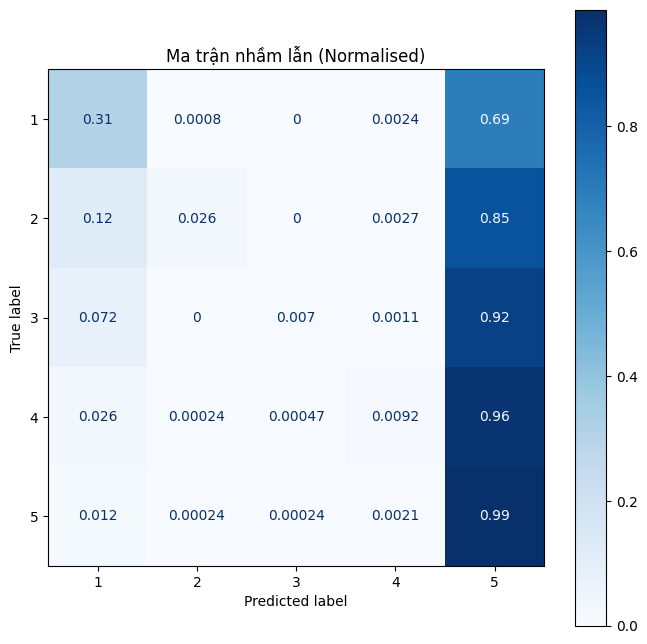

In [3]:
# 1. Chia dữ liệu thành tập train và test (80% train, 20% test)
# `stratify=y` rất quan trọng để đảm bảo tỷ lệ các lớp review_score trong tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")

# 2. Huấn luyện pipeline
print("\nBắt đầu huấn luyện mô hình...")
full_pipeline.fit(X_train, y_train)
print("Huấn luyện hoàn tất!")

# 3. Đưa ra dự đoán trên tập test
y_pred = full_pipeline.predict(X_test)

# 4. Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nĐộ chính xác (Accuracy): {accuracy:.4f}")
print("\nBáo cáo phân loại (Classification Report):")
print(report)

# 5. Trực quan hóa ma trận nhầm lẫn (Confusion Matrix)
print("\nMa trận nhầm lẫn:")
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_estimator(full_pipeline, X_test, y_test,
                                      cmap=plt.cm.Blues,
                                      ax=ax,
                                      normalize='true') # Normalize để xem tỷ lệ %
plt.title('Ma trận nhầm lẫn (Normalised)')
plt.show()

In [5]:
# Tạo thư mục models nếu chưa có
import os
os.makedirs('../models', exist_ok=True)

# Lưu pipeline vào file
model_path = '../models/lgbm_review_score_predictor.joblib'
joblib.dump(full_pipeline, model_path)

print(f"\nĐã lưu mô hình đã huấn luyện tại: {model_path}")


Đã lưu mô hình đã huấn luyện tại: ../models/lgbm_review_score_predictor.joblib
